In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
import sys
import os
sys.path.insert(0, "../")
from utils.volatility import historical_volatility
from utils.black_scholes import black_scholes_call

ticker = "MSTR"
start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)

# Download stock data
stock_price = yf.download(ticker, start=start, end=end)['Close']
volatility = historical_volatility(ticker, start, end)

# Strategy parameters
initial_balance = 10000
strike_price_factor = 5 
interest_rate = 0.05
days_to_expiration = 30
time_to_expiration = days_to_expiration / 365

print(f"Stock price shape: {stock_price.shape}")
print(f"Volatility shape: {volatility.shape}")
print(f"\nStarting balance: ${initial_balance:,.2f}")
print(f"Data range: {stock_price.index[0].date()} to {stock_price.index[-1].date()}")
print(f"Total trading days: {len(stock_price)}")

/var/folders/79/myk_nlmd2nn_yrypv2_8gg640000gn/T/ipykernel_39289/1450983500.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_price = yf.download(ticker, start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed

Stock price shape: (251, 1)
Volatility shape: (251, 1)

Starting balance: $10,000.00
Data range: 2024-01-02 to 2024-12-30
Total trading days: 251


In [31]:
# Simulation logic
balance = initial_balance
shares_owned = 0
portfolio_values = []
trades = []
call_active = False
call_strike = 0
call_expiration_day = 0

for i in range(len(stock_price)):
    current_price = stock_price.iloc[i, 0]
    current_vol = volatility.iloc[i, 0]
    current_date = stock_price.index[i]
    
    if pd.isna(current_vol):
        continue
    
    if call_active and i >= call_expiration_day:
        if current_price >= call_strike:
            proceeds = shares_owned * call_strike
            balance += proceeds
            trades.append({
                'date': current_date,
                'action': 'CALL_EXERCISED',
                'shares': shares_owned,
                'strike_price': call_strike,
                'current_price': current_price,
                'proceeds': proceeds,
                'balance': balance
            })
            shares_owned = 0
        call_active = False
    
    if shares_owned == 0:
        shares_to_buy = int(balance / current_price)
        if shares_to_buy > 0:
            cost = shares_to_buy * current_price
            balance -= cost
            shares_owned = shares_to_buy
            trades.append({
                'date': current_date,
                'action': 'BUY_STOCK',
                'shares': shares_to_buy,
                'price': current_price,
                'cost': cost,
                'balance': balance
            })
    
    if i % days_to_expiration == 0 and shares_owned > 0 and not call_active:
        strike_price = current_price * strike_price_factor
        
        # Calculate call option price using Black-Scholes
        call_premium = black_scholes_call(
            S=current_price,
            K=strike_price,
            sigma=current_vol,
            r=interest_rate,
            t=time_to_expiration
        )

        print
        
        # Collect premium for selling the call (per share)
        premium_collected = call_premium * shares_owned
        balance += premium_collected
        
        # Mark call as active
        call_active = True
        call_strike = strike_price
        call_expiration_day = i + days_to_expiration
        
        trades.append({
            'date': current_date,
            'action': 'SELL_CALL',
            'shares': shares_owned,
            'stock_price': current_price,
            'strike_price': strike_price,
            'premium': call_premium,
            'total_premium': premium_collected,
            'volatility': current_vol,
            'balance': balance
        })
    
    # Calculate portfolio value (cash + stock value)
    portfolio_value = balance + (shares_owned * current_price)
    portfolio_values.append({
        'date': current_date,
        'balance': balance,
        'shares': shares_owned,
        'stock_price': current_price,
        'portfolio_value': portfolio_value
    })

# Create DataFrames
portfolio_df = pd.DataFrame(portfolio_values)
trades_df = pd.DataFrame(trades)

print(f"\nFinal portfolio value: ${portfolio_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total return: {((portfolio_df['portfolio_value'].iloc[-1] / initial_balance - 1) * 100):.2f}%")
print(f"\nTotal trades: {len(trades_df)}")
print(f"Stock purchases: {len(trades_df[trades_df['action'] == 'BUY_STOCK'])}")
print(f"Call options sold: {len(trades_df[trades_df['action'] == 'SELL_CALL'])}")
print(f"Calls exercised: {len(trades_df[trades_df['action'] == 'CALL_EXERCISED'])}")


Final portfolio value: $43,996.33
Total return: 339.96%

Total trades: 10
Stock purchases: 1
Call options sold: 9
Calls exercised: 0



=== Trade History ===
      date    action  shares     price        cost   balance  stock_price  strike_price      premium  total_premium  volatility
2024-01-02 BUY_STOCK     145 68.514999 9934.674911 65.325089          NaN           NaN          NaN            NaN         NaN
2024-01-02 SELL_CALL     145       NaN         NaN 65.325089    68.514999    342.574997 1.091553e-17   1.582751e-15    0.649736
2024-02-14 SELL_CALL     145       NaN         NaN 65.325089    76.987999    384.939995 4.204646e-09   6.096737e-07    0.920817
2024-03-28 SELL_CALL     145       NaN         NaN 66.973286   170.455994    852.279968 1.136688e-02   1.648197e+00    1.614164
2024-05-10 SELL_CALL     145       NaN         NaN 66.973364   118.047997    590.239983 5.340950e-07   7.744378e-05    1.042549
2024-06-25 SELL_CALL     145       NaN         NaN 66.973364   149.574005    747.870026 1.450192e-09   2.102778e-07    0.883176
2024-08-07 SELL_CALL     145       NaN         NaN 66.973366   124.684998    623.

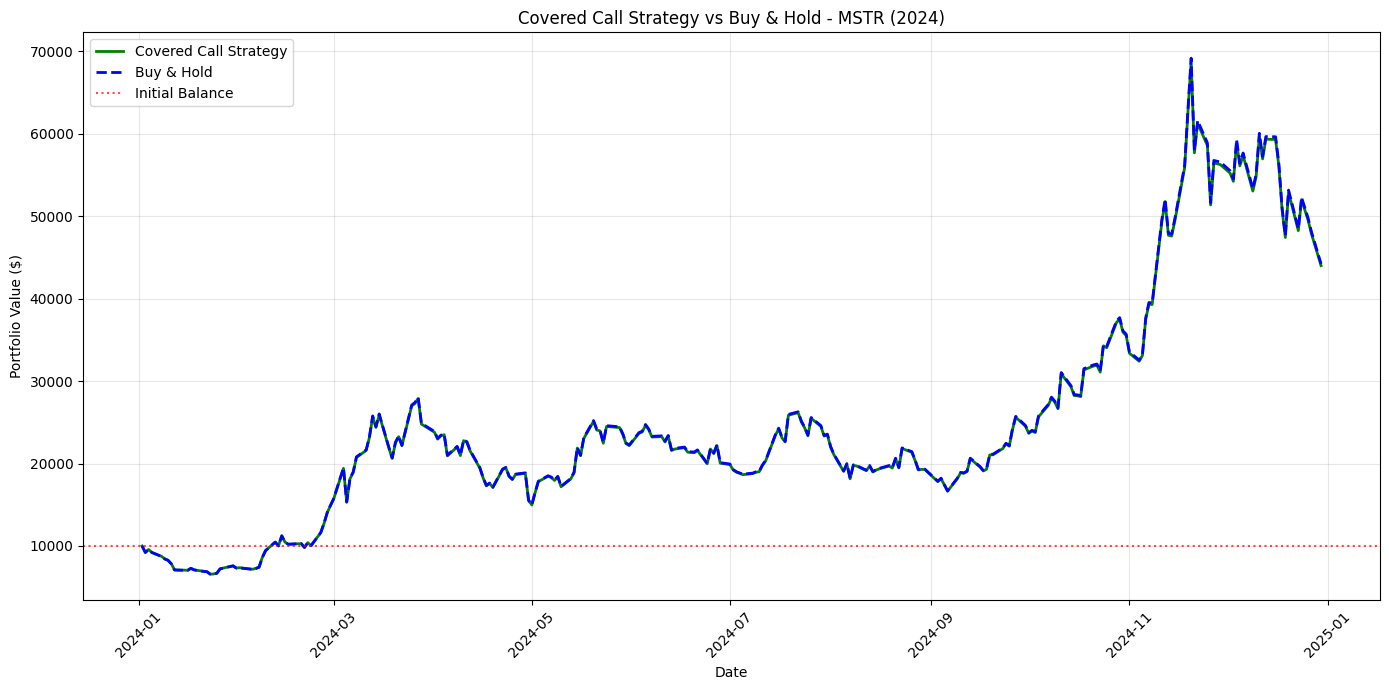

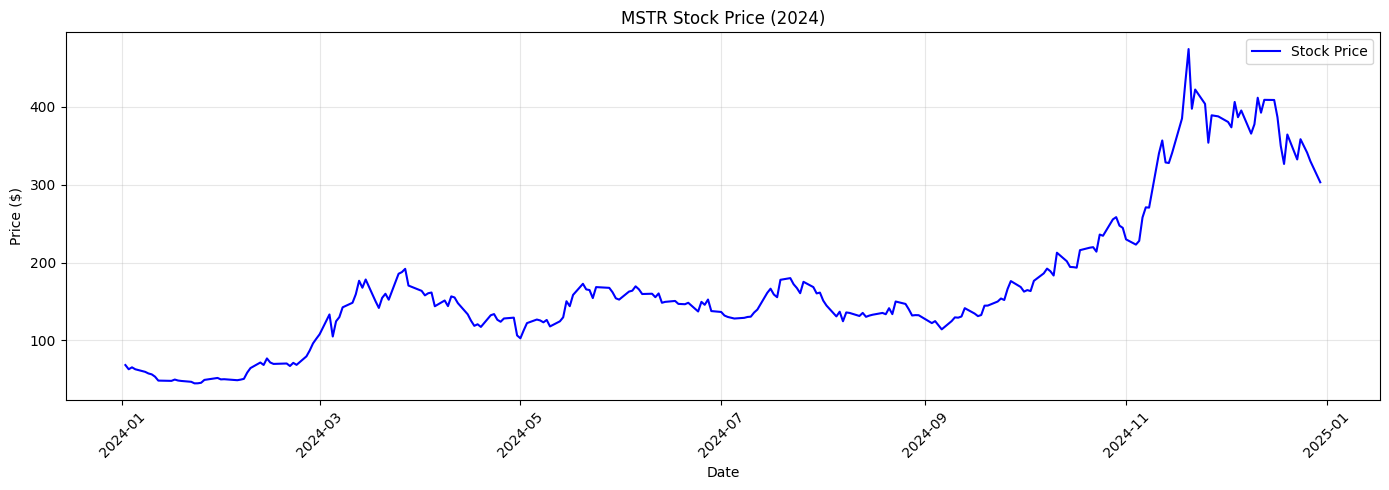

In [29]:
# Display trade details
print("\n=== Trade History ===")
print(trades_df.to_string(index=False))

# Calculate buy-and-hold performance
initial_stock_price = stock_price.iloc[0, 0]
buy_hold_shares = initial_balance / initial_stock_price
portfolio_df['buy_hold_value'] = buy_hold_shares * portfolio_df['stock_price']

# Compare final values
final_strategy_value = portfolio_df['portfolio_value'].iloc[-1]
final_buy_hold_value = portfolio_df['buy_hold_value'].iloc[-1]
strategy_return = ((final_strategy_value / initial_balance - 1) * 100)
buy_hold_return = ((final_buy_hold_value / initial_balance - 1) * 100)

print(f"\n=== Performance Comparison ===")
print(f"Covered Call Strategy: ${final_strategy_value:,.2f} ({strategy_return:.2f}%)")
print(f"Buy & Hold Strategy:   ${final_buy_hold_value:,.2f} ({buy_hold_return:.2f}%)")
print(f"Outperformance:        ${final_strategy_value - final_buy_hold_value:,.2f} ({strategy_return - buy_hold_return:.2f}%)")

# Plot portfolio value vs buy-and-hold
plt.figure(figsize=(14, 7))
plt.plot(portfolio_df['date'], portfolio_df['portfolio_value'], label='Covered Call Strategy', linewidth=2, color='green')
plt.plot(portfolio_df['date'], portfolio_df['buy_hold_value'], label='Buy & Hold', linewidth=2, color='blue', linestyle='--')
plt.axhline(y=initial_balance, color='r', linestyle=':', label='Initial Balance', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title(f'Covered Call Strategy vs Buy & Hold - {ticker} (2024)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot stock price
plt.figure(figsize=(14, 5))
plt.plot(portfolio_df['date'], portfolio_df['stock_price'], label='Stock Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{ticker} Stock Price (2024)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()